<a href="https://colab.research.google.com/github/erica-mccormick/tutorials/blob/main/Intro_to_Watersheds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Erica McCormick | October 2021

#**Accessing and Plotting Data for USGS Watersheds via Google Earth Engine**

#**Other Related Colabs:**

*These scripts are not necessarily finished or fully functioning.*

**(THIS COLAB IS A USEFUL TUTORIAL)** Skillshare colab with basics and an intro to GEE: https://colab.research.google.com/drive/1HAsF3i5zwDwb8DH8PZnRoacDdUuP5rwB#scrollTo=00geuX0HrNL3

**Extract timeseries**:

for a single watershed id: https://colab.research.google.com/drive/12Rffbu6fTrhM3y9Zbaa1WUrR66xzkbMj?authuser=1

Annual sum timeseries for a list of watersheds IDs (check these before use): https://colab.research.google.com/drive/1rLZRaDdHHj5szS8ogHtEkjDd5nON9lrx?authuser=1

#**Imports & Set-up**

## Imports and initializing GEE and GoogleDrive integration

In this code, we will use several packages which are not automatically available. We will therefore need to install them before importing.

In [ ]:
pip install geemap

     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 8.6 MB 45.0 MB/s 
     |████████████████████████████████| 1.2 MB 49.1 MB/s 
     |████████████████████████████████| 1.3 MB 59.4 MB/s 
     |████████████████████████████████| 130 kB 44.6 MB/s 
     |████████████████████████████████| 216 kB 36.1 MB/s 
     |████████████████████████████████| 98 kB 4.9 MB/s 
     |████████████████████████████████| 219 kB 42.6 MB/s 
     |████████████████████████████████| 3.3 MB 52.0 MB/s 
     |████████████████████████████████| 76 kB 6.2 MB/s 
     |████████████████████████████████| 95 kB 4.5 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 52.8 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 428 kB 50.5 MB/s 
     |████████████████████████████████| 395 kB 50.0 MB/s 
     |█████████████████████

In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 33.4 MB/s 


In [ ]:
pip install contextily

     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:
import geemap
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import os
import json
from shapely.geometry import box
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [ ]:
import ee
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=nAxwn-ph9N5h3SpE1ThwndPuc-dcqklFQJJH-7n_iME&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhEtRKD2ZaLkcJkgvs7OY_PylGfE89-CBnvVXrMZe-tqaKljdjADKk

Successfully saved authorization token.


In [ ]:
ee.Initialize()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Specify directory for saving data in GoogleDrive

It is HIGHLY recommended to make a folder within your Drive and specify that as the working directory.

In [ ]:
work_dir = '/content/drive/MyDrive/'

## Specify location
This colab is set up to extract data from a single USGS watershed with a gage ID.

In [ ]:
gage = '11475560' # Elder Creek

## Specify duration for timeseries extraction
Specify the start/stop dates for the various products we will be extracting a timeseries for.

In [ ]:
# Start/stop for USGS streamflow (Q)
start_flow = '2007-10-01'
stop_flow = '2017-10-01'

# Start/stop for PRISM (precipitation and temperature for PET)
start_prism = '2007-10-01'
stop_prism = '2017-10-01'

# Start/stop for PML ET
start_pml = '2007-10-01'
stop_pml = '2017-10-01'

# Set up functions for later

This function takes several inputs, including the USGS gage ID and our desired output file format, and returns geometry files of the watershed as well as the geometry of a bounding box around the watershed. This function will also print out a map of the watershed area, the flowlines, the bounding box, and a basemap. You can save this image by right-clicking on it. By changing the output_type parameter to 'ee' or 'gpd', this function will return the shape of the watershed in either Google Earth Engine format or Geopandas format.

In [ ]:
def getLocation(gage, output_type = 'ee', work_dir = work_dir):

  #Importing basin geometery 
  print('Data is being retrieved from:')
  url = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%gage
  print(url)
  sites = gpd.read_file(url)   

  # Importing flow line geometry 
  flowlines=gpd.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/navigation/UM/flowlines?f=json&distance=1000'%gage)
  #print('\n USGS Basin imported at gage: ' + gage + 'CRS: ' + str(sites.crs))

  out_path = os.path.join(work_dir, str(gage)+".geojson")
  with open(out_path, 'w') as f:
    sites.to_file(out_path, driver = "GeoJSON")

  out_path = os.path.join(work_dir, str(gage)+"_bbox.geojson")
  with open(out_path, 'w') as f:
    sites.to_file(out_path, driver = "GeoJSON")
    
  # getting bounding box with 0.05 degree buffer around basin shape
  bbox_gdf = gpd.GeoDataFrame([1], geometry=[box(*sites.buffer(0.05).total_bounds)], crs=sites.crs)
  
  # Print out a map of the watershed
  loc_plot = sites.boundary.plot(color='darkgreen', figsize=(8, 8), label='Site Area')
  flowlines.plot(ax=loc_plot, label='Flow Lines')
  bbox_gdf.boundary.plot(ax=loc_plot, color='black', label='Bounding Box')
  ctx.add_basemap(ax=loc_plot, crs=sites.crs.to_string())
  plt.legend()
  plt.title('USGS Gage at gage: '+ gage)
  plt.show()

  #returning bounding box geometry as geopandas dataframe or ee feature collection
  if output_type=='gpd': return sites, bbox_gdf
  elif output_type=='ee': 
      # if want outputs as ee feature collections - this section will run
      bbox_coords = [item for item in bbox_gdf.geometry[0].exterior.coords]
      bbox_geom = ee.Geometry.Polygon(bbox_coords)
      sites_features = []
      poly_coords = [item for item in sites.geometry[0].exterior.coords]
      temp = ee.Feature(ee.Geometry.Polygon(coords=poly_coords), {'Gage':int(gage)})
      sites_features = ee.FeatureCollection([temp])
      return sites_features, bbox_geom


This function runs a subset of the above function, but just returns the centroid latitude and longitude of the basin.

In [ ]:
def get_latlon(gage):
  basin = gpd.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%gage)
  site_lat=basin.to_crs('epsg:4326').geometry[0].centroid.y
  site_lon=basin.to_crs('epsg:4326').geometry[0].centroid.x
  return site_lat, site_lon

This function takes the gage ID and start and end dates and returns a dataframe with the daily USGS streamflow in various units.

In [ ]:
def getFlow(gage = gage, start_flow = start_flow, stop_flow = stop_flow):
    site = str(gage)
    basin = gpd.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%gage)

    # url of flow data (usgs)
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start_flow+'&end_date='+stop_flow
    print('Data is being retrieved from:')
    print(url)
    # get df
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site_number', 'datetime', 'q_cfs', 'a'] 
    df['id'] = pd.to_datetime(df.datetime)
    df = df[['q_cfs','id']]
    df['q_cfs'] = df['q_cfs'].astype(float, errors='ignore')  #this is needed because sometimes there are non-numeric entries and we want to ignore them
    df['q_m3day']= (86400*df['q_cfs'])/(35.31) #m3/day
    # Calculate drainage area in m^2
    drainage_area_m2=basin.to_crs('epsg:26910').geometry.area 

    df['q_m'] = df['q_m3day'] / float(drainage_area_m2)
    df['q_mm'] = df['q_m3day'] / float(drainage_area_m2) * 1000

    df.set_index('id',inplace=True) 
    print('\n', df.head())
    return df

The following 2 functions use geemap to extract single bands of the asset PRISM and PML. Because of the limit on extractions using the geemap method (see [this colab](https://colab.research.google.com/drive/1Yq_0Hyk5IwK4Dbn9qntFpmYz9Qkgd3YL?authuser=1#scrollTo=2M7YMoPNwDws), section "Extraction Method I: GEEMAP", for more information), it is easiest to do the extractions one band at a time. Because of the similarity from band to band, we can make a function to avoid repeating big chunks of code over and over again! NOTE This function will save 2 files to your working directory (work_dir) in your GoogleDrive: a raw file and a file with the final, cleaned up dataframe.

In [ ]:
def extract_prism_geemap(band_name, ft_collection, start_prism = start_prism, stop_prism = stop_prism):
  prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81d").select(band_name)

  prism_band = prism.filterDate(start_prism, stop_prism)
  prism_band = prism_band.toBands()

  out_csv = os.path.join(work_dir, gage+'_prism_'+ band_name + '_raw.csv')
  geemap.extract_values_to_points(ft_collection, prism_band, out_csv)

  # Import data you just exported to clean it and make the df nicer
  raw = pd.read_csv(out_csv).melt()

  df = pd.DataFrame()
  df[band_name] = raw['value'][:-1]
  df['Date'] = [pd.to_datetime(i.split('_')[0], format = "%Y%m%d", errors='coerce')  for i in raw['variable'].values[:-1]]

  # Re-export final df
  out_csv = os.path.join(work_dir, gage+'_'+ band_name + '.csv')

  with open(out_csv, 'w') as f:
    df.to_csv(f)

  #print(df.head())
  return df

In [ ]:
def extract_pml_geemap(band_name, ft_collection, start_pml = start_pml, stop_pml = stop_pml):

  pml = ee.ImageCollection("CAS/IGSNRR/PML/V2").select(band_name) #mm d-1

  pml = pml.filterDate(start_pml, stop_pml)
  pml_image = pml.toBands().reproject(crs = 'EPSG:4326', scale = 500)

  out_csv = os.path.join(work_dir, gage+ '_pml_'+ band_name + '_raw.csv')
  geemap.extract_values_to_points(ft_collection, pml_image, out_csv)

  # Read in data again
  raw = pd.read_csv(out_csv).melt()
  df = pd.DataFrame()
  df[band_name] = raw['value'][:-1]
  df['Date'] = [pd.to_datetime(i[:-3], format = "%Y-%m-%d", errors = 'coerce')  for i in raw['variable'].values[:-1]]

  #print(df.head())
  return df

#**Extract USGS data**

Let's use the functions from above to extract the shape and streamflow from USGS websites.

Data is being retrieved from:
https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-14046890/basin?f=json


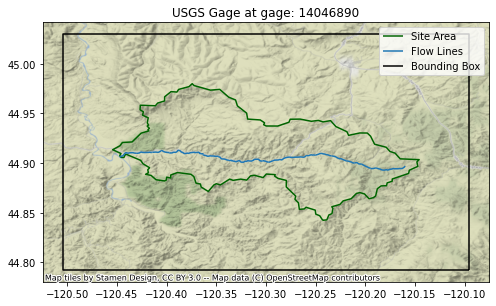

In [ ]:
ft_collection, bbox_geom = getLocation(gage = gage, output_type = 'ee', work_dir = work_dir)

In [ ]:
q = getFlow()

Data is being retrieved from:
https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=14046890&referred_module=sw&period=&begin_date=2007-10-01&end_date=2017-10-01

             q_cfs      q_m3day       q_m      q_mm
id                                                
2007-10-04   0.48  1174.511470  0.000007  0.006915
2007-10-05   0.47  1150.042481  0.000007  0.006771
2007-10-06   0.47  1150.042481  0.000007  0.006771
2007-10-07   0.45  1101.104503  0.000006  0.006483
2007-10-08   0.44  1076.635514  0.000006  0.006339


#**Extract GEE Timeseries**

Now we can use the featureCollection we made (which contains a single feature, the watershed) and use the package "geemap" to extract timeseries of precipitation and ET. We will also use the temperature bands of PRISM (where we get precipitation from as well) to calculate PET using the Hargreaves method.

###PRISM

We will use the PRISM dataset for precipitation, as well as for the minimum, maximum, and mean temperature required to calculate PET using the Hargreaves method.

In [ ]:
# Let's see what bands are available with PRISM
prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81d").first()
prism.bandNames().getInfo()

['ppt', 'tmean', 'tmin', 'tmax', 'tdmean', 'vpdmin', 'vpdmax']

In [ ]:
ppt = extract_prism_geemap(band_name = 'ppt', ft_collection = ft_collection, start_prism=start_prism, stop_prism=stop_prism)

NameError: ignored

In [ ]:
# Since we set up the rest of the input arguments in the definition of the function itself, we don't need to repeat them when we call the function.
tmin = extract_prism_geemap(band_name = 'tmin', ft_collection = ft_collection)
tmax = extract_prism_geemap(band_name = 'tmax', ft_collection = ft_collection)
tmean = extract_prism_geemap(band_name = 'tmean', ft_collection = ft_collection)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/PhysHydro/14046890_prism_tmin_raw.csv
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/PhysHydro/14046890_prism_tmax_raw.csv
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/PhysHydro/14046890_prism_tmean_raw.csv


We can combine all 4 of these dataframes into a single dataframe if we so choose.

In [ ]:
prism_df = ppt.merge(tmin, how = 'inner', on ='Date')
prism_df = prism_df.merge(tmax, how = 'inner', on = 'Date')
prism_df = prism_df.merge(tmean, how = 'inner', on = 'Date')
prism_df.head()

,ppt,Date,tmin,tmax,tmean
0,0.473,2007-10-02,3.943,14.028,8.985001
1,2.670,2007-10-03,5.229,16.730,10.979000
2,1.202,2007-10-04,1.317,13.433,7.374001
3,2.455,2007-10-05,0.800,11.494,6.147000
4,0.636,2007-10-06,-0.421,11.435,5.507000


Uncomment this chunk to export this dataframe as a csv.

In [ ]:
#out_csv = os.path.join(work_dir, gage+'_all_prism' + '.csv')
#with open(out_csv, 'w') as f:
#  prism_df.to_csv(f)

###PML ET

For more ET extractions, see the code [here](https://colab.research.google.com/drive/1Yq_0Hyk5IwK4Dbn9qntFpmYz9Qkgd3YL?authuser=1#scrollTo=2M7YMoPNwDws). All you need to do is replace the ft_collection from a lat/long with the ft_collection of the watershed we create at the beginning of this script.

In [ ]:
Es_PML = extract_pml_geemap(band_name = 'Es', ft_collection = ft_collection)
Ec_PML = extract_pml_geemap(band_name = 'Ec', ft_collection = ft_collection)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/PhysHydro/14046890_pml_Es_raw.csv
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/PhysHydro/14046890_pml_Ec_raw.csv


In [ ]:
# Combine Es and Ec into one df, add columns, and export
pml_df = Es_PML.merge(Ec_PML, how = 'inner', on = 'Date')
pml_df['ET'] = pml_df['Es'] + pml_df['Ec']

# Re-export final df
#out_csv = os.path.join(work_dir, gage+'_all_pml' + '.csv')
#with open(out_csv, 'w') as f:
#  pml_df.to_csv(f)

pml_df.head()

,Es,Date,Ec,ET
0,0.925797,2007-10-08,0.113280,1.039077
1,0.708248,2007-10-16,0.080885,0.789133
2,0.494382,2007-10-24,0.095921,0.590302
3,0.140201,2007-11-01,0.090291,0.230493
4,0.170490,2007-11-09,0.056429,0.226919


#**Calculate PET using Hargreaves method**

These two functions use the equations below from Hargreave and Samani (1985) to calculate PET. The first function calculates daily exterrestrial radiation (Rext) using the given equation from Allen et al. (1998). This equation requires the latitude of the watershed as an input and proceeds to calculate a generic Rext value for each julian day. We combine the information about daily temperature (from PRISM) with the Rext to calculate PET.

Notice that the first function (getRA) is used in the second function (getPET) but is never called on its own. This is a handy way to break down complicated code into manageable, more easily testable, steps. In fact, there is one *more* hidden function we are using here... (hint: it is called getlatlon, and it is given at the beginning of this document!).

Hargreave and Samani 1985: Equation:

Ep = 0.0023 · (Tmean + 17.8)·(Tmax − Tmin)^0.5 · 0.408 · Rext

Rext = Exterrestrial radiation [MJ m-2 day-1] (Allen et al 1998)

Equation:
Ra = 1440/pi(Gsc)(dr)[ws*sin(ϕ)*sin(δ)+cos(ϕ)*cos(δ)*sin(ws)]

**Functions to calculate Rext (aka Ra) and PET:**

In [ ]:
def getRA(site_lat_decimal):

  ## J (julian day)
  J = (np.linspace(1,365,365))

  ## Gsc (solar constant)  [MJ m-2 day -1] 
  Gsc = 0.0820

  ## inverse relative distance Earth-Sun
  dr = 1+0.033*np.cos(((2*np.pi)/365)*J) 

  ## delta = solar declination [rad]
  delta = 0.409*np.sin(((2*np.pi)/365)*J-1.39)  

  ## psi [rad] = convert decimal latitude to radians
  psi = (np.pi/180)*(32.3863) 

  ## omega_s (ws)= solar time angle at beginning of period [rad]
  omega_s = np.arccos(-np.tan(psi)*np.tan(delta)) 


  ### RA = Put it all together

  ## [ws * sin(psi) * sin(delta) + cos(psi) * cos(delta) * sin(ws)]
  angles = omega_s * np.sin(psi) * np.sin(delta) + np.cos(psi) * np.cos(delta) * np.sin(omega_s)

  RA = ((24*60)/np.pi) * Gsc * dr * angles

  df = pd.DataFrame()
  df['RA'] = RA
  df['J'] = J
  df['J']= df['J'].astype(int)
  return df

# tmin, tmax, tmean are specifying the names of the columns in the prism df (called "p" here)
def getPET(gage, p, tmin = 'tmin', tmax = 'tmax', tmean = 'tmean'):
  #p['id'] = p.index

  # get RA (extraterrestrial radiation) with julian day column
  site_lat, site_lon = get_latlon(gage)
  RA_df = getRA(site_lat)

  # add a julian day column to the original prism extraction df
  p['J'] = pd.to_datetime(p['Date']).dt.strftime('%j')
  p = p.dropna()
  p['J'] = p['J'].astype(int)


  # merge prism df with RA
  p = p.merge(RA_df, how='left', on=['J'])

  # calculate PET (Hargreave and Semani 1985)
  # Ep = 0.0023 · (Tmean + 17.8)·(Tmax − Tmin)^0.5 · 0.408 · Rext
  Krs = 0.0023 # Erica changed this from 0.00023 on Oct 15, 2021
  p['PET'] = Krs * p['RA'] * np.sqrt(p[tmax] - p[tmin]) * (p[tmean] + 17.8)

  p['Date'] = pd.to_datetime(p['Date'])
  return p


Now we can call the function getPET, which uses the function getRA and getlatlon, and we have our PET dataframe!

In [ ]:
pet_df = getPET(gage, p = prism_df, tmin = 'tmin', tmax = 'tmax', tmean = 'tmean')
pet_df.head()

,ppt,Date,tmin,tmax,tmean,J,RA,PET
0,0.473,2007-10-02,3.943,14.028,8.985001,275,29.100477,5.693215
1,2.670,2007-10-03,5.229,16.730,10.979000,276,28.888647,6.484829
2,1.202,2007-10-04,1.317,13.433,7.374001,277,28.676672,5.779476
3,2.455,2007-10-05,0.800,11.494,6.147000,278,28.464637,5.126898
4,0.636,2007-10-06,-0.421,11.435,5.507000,279,28.252626,5.214854


#**Plot & Explore**

##**Cumulative wateryear plots**

Let's set up one more function to help us process and plot the data. We will make a function that adds more columns to our dataframe. These columns will have the wateryear cumulative sum of our variables.

In [ ]:
def wtryear_cum(df, et = 'ET', pet = 'PET', ppt = 'ppt', q = 'q_mm'):
    df = df.set_index(pd.to_datetime(df['Date']))
    df['wateryear'] = np.where(~df.index.month.isin([10,11,12]),df.index.year,df.index.year+1)

    if et != np.nan:
        df['cum_'+ et] = df.groupby(['wateryear'])[et].cumsum()
    if pet != np.nan:
        df['cum_'+ pet] = df.groupby(['wateryear'])[pet].cumsum()
    if ppt != np.nan:
        df['cum_'+ ppt] = df.groupby(['wateryear'])[ppt].cumsum()
    if q in df.columns:
        if q != np.nan:
            df['cum_'+ q] = df.groupby(['wateryear'])[q].cumsum()

    return df
    

In [ ]:
# If our dataframes are the same size (ie start/stop dates are the same), then we can combine our data into one df
df = pet_df.merge(pml_df, how = 'outer', on = 'Date')
df = df.merge(q, how = 'outer', left_on = 'Date', right_on = q.index)

# We also need to interpolate our ET to daily, because at the moment it is at 8 day resolution!
df = df.interpolate(axis = 'index', method='linear', limit = 32, limit_direction='both', limit_area='inside')

In [ ]:
df_cumulative = wtryear_cum(df)
df_cumulative = df_cumulative.dropna()
df_cumulative.head()

,ppt,Date,tmin,tmax,tmean,J,RA,PET,Es,Ec,ET,q_cfs,q_m3day,q_m,q_mm,wateryear,cum_ET,cum_PET,cum_ppt,cum_q_mm
Date,,,,,,,,,,,,,,,,,,,,
2007-10-08,0.000,2007-10-08,6.214,20.065001,13.139001,281.0,27.829022,7.370087,0.925797,0.113280,1.039077,0.44,1076.635514,0.000006,0.006339,2008.0,1.039077,41.083942,7.436,0.033277
2007-10-09,0.000,2007-10-09,5.449,18.113001,11.781000,282.0,27.617602,6.686704,0.898603,0.109231,1.007834,0.42,1027.697536,0.000006,0.006050,2008.0,2.046911,47.770646,7.436,0.039328
2007-10-10,0.838,2007-10-10,6.434,21.764999,14.099001,283.0,27.406553,7.873078,0.871410,0.105182,0.976591,0.43,1052.166525,0.000006,0.006194,2008.0,3.023502,55.643724,8.274,0.045522
2007-10-11,4.498,2007-10-11,2.622,13.999000,8.310000,284.0,27.195962,5.508749,0.844216,0.101132,0.945348,0.42,1027.697536,0.000006,0.006050,2008.0,3.968851,61.152474,12.772,0.051572
2007-10-12,0.000,2007-10-12,2.534,14.088000,8.311001,285.0,26.985919,5.508771,0.817022,0.097083,0.914105,0.39,954.290569,0.000006,0.005618,2008.0,4.882956,66.661245,12.772,0.057191


In [ ]:
df_cumulative.tail()

,ppt,Date,tmin,tmax,tmean,J,RA,PET,Es,Ec,ET,q_cfs,q_m3day,q_m,q_mm,wateryear,cum_ET,cum_PET,cum_ppt,cum_q_mm
Date,,,,,,,,,,,,,,,,,,,,
2017-09-27,0.0,2017-09-27,7.989,21.493000,14.740001,270.0,30.154558,8.293342,0.384322,0.069407,0.453729,0.95,2324.553951,0.000014,0.013685,2017.0,302.960134,2739.715500,410.151001,34.491162
2017-09-28,0.0,2017-09-28,9.287,23.295000,16.290001,271.0,29.944688,8.787447,0.389351,0.068446,0.457797,0.94,2300.084962,0.000014,0.013541,2017.0,303.417931,2748.502947,410.151001,34.504704
2017-09-29,0.0,2017-09-29,9.942,26.433001,18.187000,272.0,29.734265,9.994342,0.394379,0.067486,0.461865,0.94,2300.084962,0.000014,0.013541,2017.0,303.879796,2758.497289,410.151001,34.518245
2017-09-30,0.0,2017-09-30,5.821,19.934999,12.877001,273.0,29.523368,7.825853,0.399408,0.066526,0.465933,0.95,2324.553951,0.000014,0.013685,2017.0,304.345729,2766.323142,410.151001,34.531931
2017-10-01,0.0,2017-10-01,4.674,14.497000,9.585000,274.0,29.312078,5.786411,0.199704,0.033263,0.232967,0.94,2300.084962,0.000014,0.013541,2018.0,0.232967,5.786411,0.000000,0.013541


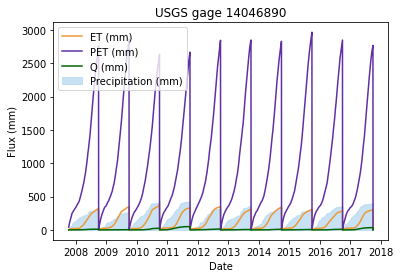

In [ ]:
plot_data = df_cumulative.dropna().copy()
plt.fill_between(plot_data['Date'], 0, plot_data['cum_ppt'],color='#b1d6f0', label='Precipitation (mm)', alpha = 0.7)

plt.plot(plot_data['Date'], plot_data['cum_ET'], '-',color='#ED9935', label='ET (mm)')
plt.plot(plot_data['Date'], plot_data['cum_PET'], '-',color='#612fa3', label='PET (mm)')
plt.plot(plot_data['Date'], plot_data['cum_q_mm'], color='darkgreen', label='Q (mm)')
plt.legend(loc = 'best')
plt.xlabel('Date')
plt.ylabel('Flux (mm)')
plt.title('USGS gage '+ gage);

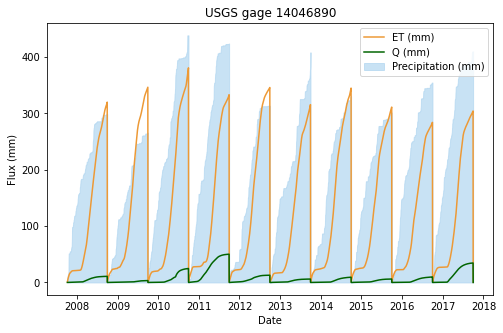

In [ ]:
plt.figure(figsize=(8, 5))

plot_data = df_cumulative.dropna().copy()

plt.fill_between(plot_data['Date'], 0, plot_data['cum_ppt'],color='#b1d6f0', label='Precipitation (mm)', alpha = 0.7)

plt.plot(plot_data['Date'], plot_data['cum_ET'], '-',color='#ED9935', label='ET (mm)')
#plt.plot(plot_data['Date'], plot_data['cum_PET'], '-',color='#612fa3', label='PET (mm)')

plt.plot(plot_data['Date'], plot_data['cum_q_mm'], color='darkgreen', label='Q (mm)')

plt.legend(loc = 'best')
plt.xlabel('Date')
plt.ylabel('Flux (mm)')
plt.title('USGS gage '+ gage);

##**2.5 FLOOD FREQUENCY CURVE**

Let's go back to our USGS discharge dataframe (*q*) and plot the frequency of flooding.

In [ ]:
df_ff = q.resample('AS').max()
df_ff.head()

,q_cfs,q_m3day,q_m,q_mm
id,,,,
2007-01-01,0.48,1174.511470,0.000007,0.006915
2008-01-01,6.93,16957.009346,0.000100,0.099832
2009-01-01,4.85,11867.459643,0.000070,0.069868
2010-01-01,44.70,109376.380629,0.000644,0.643935
2011-01-01,24.00,58725.573492,0.000346,0.345737


In [ ]:
# Sort data smallest to largest
df_ff_sorted = df_ff.sort_values(by="q_mm")

df_ff_sorted

,q_cfs,q_m3day,q_m,q_mm
id,,,,
2007-01-01,0.48,1174.511470,0.000007,0.006915
2015-01-01,3.74,9151.401869,0.000054,0.053877
2013-01-01,3.87,9469.498726,0.000056,0.055750
2009-01-01,4.85,11867.459643,0.000070,0.069868
2014-01-01,6.00,14681.393373,0.000086,0.086434
2016-01-01,6.75,16516.567545,0.000097,0.097239
2008-01-01,6.93,16957.009346,0.000100,0.099832
2012-01-01,10.70,26181.818182,0.000154,0.154141
2017-01-01,22.10,54076.465590,0.000318,0.318366


In [ ]:
# Count total obervations
n = df_ff_sorted.shape[0]

# Add a numbered column 1 -> n to use in return calculation for rank
df_ff_sorted.insert(0, 'rank', range(1, 1 + n))

In [ ]:
# Calculate probability - note you may need to adjust this value based upon the time period of your data
df_ff_sorted["probability"] = (
    (n - df_ff_sorted["rank"] + 1) / (n + 1))
df_ff_sorted["return-years"] = (
    1 / df_ff_sorted["probability"])
df_ff_sorted

,rank,q_cfs,q_m3day,q_m,q_mm,probability,return-years
id,,,,,,,
2007-01-01,1,0.48,1174.511470,0.000007,0.006915,0.916667,1.090909
2015-01-01,2,3.74,9151.401869,0.000054,0.053877,0.833333,1.200000
2013-01-01,3,3.87,9469.498726,0.000056,0.055750,0.750000,1.333333
2009-01-01,4,4.85,11867.459643,0.000070,0.069868,0.666667,1.500000
2014-01-01,5,6.00,14681.393373,0.000086,0.086434,0.583333,1.714286
2016-01-01,6,6.75,16516.567545,0.000097,0.097239,0.500000,2.000000
2008-01-01,7,6.93,16957.009346,0.000100,0.099832,0.416667,2.400000
2012-01-01,8,10.70,26181.818182,0.000154,0.154141,0.333333,3.000000
2017-01-01,9,22.10,54076.465590,0.000318,0.318366,0.250000,4.000000


Text(0.5, 1.0, 'Flood frequency at 14046890')

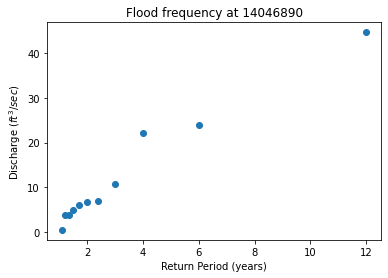

In [ ]:
plt.scatter(df_ff_sorted['return-years'],df_ff_sorted['q_cfs'])
plt.xlabel('Return Period (years)')
plt.ylabel('Discharge ($ft^3/sec$)')
plt.title('Flood frequency at ' + str(gage))

Best Fit Slope = 3.8276752880940714


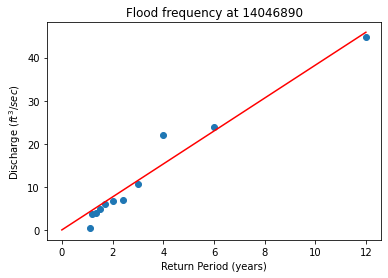

In [ ]:
def linear_model(x, m):
  return m*x

params, covariance = scipy.optimize.curve_fit(linear_model,df_ff_sorted['return-years'], df_ff_sorted['q_cfs'])
m = params[0]
m_err = covariance[0,0]**.5
x_fit=[]
x_fit_bounds=[0,12]
for i in range(1000):
  x_fit.append(float(i)*x_fit_bounds[1]/1000)
y_fit=[]
for i in range(len(x_fit)):
  y_fit.append(linear_model(x_fit[i],m))

plt.plot(x_fit, y_fit, 'r')
plt.scatter(df_ff_sorted['return-years'],df_ff_sorted['q_cfs'])
plt.xlabel('Return Period (years)')
plt.ylabel('Discharge ($ft^3/sec$)')
plt.title('Flood frequency at ' + str(gage))

print('Best Fit Slope =', m)




# plt.plot()
# model.fit(df_ff_sorted['return-years'],df_ff_sorted['q_cfs'])